# 커스텀 함수

In [203]:
# 필요한 라이브러리 선언
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [204]:
'''
목적 : Min-Max Scaling 함수
'''
def min_max_scaling(target_list):
    return (target_list - min(target_list)) / (max(target_list) - min(target_list))

In [228]:
'''
목적 : DNN 모델링
'''
def dnn_modeling(input_size):
    print("########## Start DNN Modeling ##########")
    # 모델 구조 정의하기
    model = Sequential()  

    #입력 8개로부터 전달받는 24개 노드의 layer 생성
    model.add(Dense(24, input_shape=(input_size, ), activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='linear'))        #회귀모형(regression) 구축을 위해서 linear 활성함수 사용

    # 모델 구축하기 (MAE : 평균 제곱 오차)
    model.compile(
            loss='mse',         # mean_squared_error(평균제곱오차)의 alias
            optimizer='adam',   # 최적화 기법 중 하나
            metrics=['mae'])    # 실험 후 관찰하고 싶은 metric 들을 나열함.
    
    return model


In [206]:
'''
목적 : 데이터를 분석하기 좋은 형태로 가공
'''
def predefine_data(dataset, meta_col, threshold_ratio):

    print("########## Start Predefine Data ##########")
    # 이상 데이터를 제거
    null_rate = (dataset.isnull().sum()/dataset.shape[0]) * 100

    null_col = []

    for i, x in enumerate(null_rate.index):
        if null_rate[i] > threshold_ratio:
            null_col.append(x)

    # 각 Column 별 Null 값 비율이 임계치보다 높을 경우 삭제
    dataset = dataset.drop(columns=null_col)
    print(f'Droppd columns are: {null_col}')

    # 중복 데이터 삭제
    engine_list = dataset['engine_no'].drop_duplicates().values

    ###### Summary ######
    print(dataset.shape)
    print(dataset.columns)
    
    print("########## End Predefine Data ##########")
    
    return dataset
   

In [207]:
'''
목적 : 각 feature에 대해 우선순위 부여
'''
# See which features are the most important
def set_feature_priority(X, y):
    reg = RandomForestRegressor()
    reg = RandomForestRegressor(n_estimators = 200, max_depth = 15)
    reg.fit(X, y)
    y_pred = reg.predict(X)
    print("complete")
    
    importances = reg.feature_importances_
    columns=['col', 'val']
    pd_importances = pd.DataFrame(columns=columns)
    for i, x in enumerate(X.columns):
        pd_importances.loc[i] = [x, importances[i]]
    
    # Get the most important columns in top10    
    important_col = pd_importances.sort_values(by='val', ascending=False).reset_index()
    print(important_col)
    
    return important_col

# 분석에 사용할 데이터 READ 및 가공

In [208]:
dataset = pd.read_csv('./train_data/train_data.csv')

# 분석에 불필요한 데이터를 메타데이터로 정의
metacol = ['engine_no', 'time_in_cycles']
threshold_ratio = 99.5 # (%)

dataset = predefine_data(dataset, metacol, threshold_ratio)

########## Start Predefine Data ##########
Droppd columns are: ['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']
(160359, 27)
Index(['engine_no', 'time_in_cycles', 'op_setting_1', 'op_setting_2',
       'op_setting_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'RUL'],
      dtype='object')
########## End Predefine Data ##########


# 전체 Feature에 대해 correlation 점수 부여

In [209]:
X = dataset.drop(columns=metacol).iloc[:,:-1]
y = dataset['RUL'].values

feature_priority = set_feature_priority(X, y)


complete
    index           col       val
0      15     sensor_13  0.333341
1      13     sensor_11  0.205074
2      17     sensor_15  0.128627
3      11      sensor_9  0.075164
4       6      sensor_4  0.050673
5       8      sensor_6  0.050481
6      16     sensor_14  0.030732
7      14     sensor_12  0.024796
8       9      sensor_7  0.021697
9      10      sensor_8  0.016256
10      4      sensor_2  0.012637
11      5      sensor_3  0.012396
12     23     sensor_21  0.011127
13     22     sensor_20  0.008560
14      0  op_setting_1  0.008111
15      1  op_setting_2  0.005043
16     19     sensor_17  0.004384
17     12     sensor_10  0.000620
18     18     sensor_16  0.000268
19     20     sensor_18  0.000005
20      3      sensor_1  0.000005
21      7      sensor_5  0.000003
22     21     sensor_19  0.000000
23      2  op_setting_3  0.000000


# 데이터 스케일링 및 Target 데이터 분리

In [210]:
# 입력 데이터에 대해 Standard 스케일링 (평균 0 / 분산 1)
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc_df = pd.DataFrame(X_sc, columns=[X.columns], index=X.index)

# 출력 데이터에 대해 Min-Max 스케일링
y = min_max_scaling(y)
X_train, X_test, y_train, y_test = train_test_split(X_sc_df, y, test_size=0.3, random_state=42)


# 12개 Feature를 사용하여 DNN 모델링

In [239]:
model = dnn_modeling(12)

model.summary()

########## Start DNN Modeling ##########
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_172 (Dense)           (None, 24)                312       
                                                                 
 dense_173 (Dense)           (None, 24)                600       
                                                                 
 dense_174 (Dense)           (None, 12)                300       
                                                                 
 dense_175 (Dense)           (None, 1)                 13        
                                                                 
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


# 방법1 : 우선순위가 높은 12개 데이터를 활용하여 분석 수행

In [240]:
'''
10개에 한 번씩 업데이터 실행
0:미출력, 1:진행상황출력, 2:에포크당 출력
'''
feature_col = feature_priority['col'][:12].values

hist = model.fit(
    X_train[feature_col], y_train,
    batch_size=10,    
    epochs=2,       
    validation_split=0.2,  
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],  
    verbose=2)

# 테스트 데이터 입력
scores = model.evaluate(X_test[feature_col], y_test)
print('test_loss: ', scores[0])
print('test_mae: ', scores[1])


Epoch 1/2


2022-04-05 14:44:58.291068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-05 14:45:25.820583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8980/8980 - 33s - loss: 0.0129 - mae: 0.0843 - val_loss: 0.0106 - val_mae: 0.0731 - 33s/epoch - 4ms/step
Epoch 2/2
8980/8980 - 33s - loss: 0.0110 - mae: 0.0765 - val_loss: 0.0105 - val_mae: 0.0745 - 33s/epoch - 4ms/step
1504/1504 [==============================] - 5s 3ms/step - loss: 0.0104 - mae: 0.0746
test_loss:  0.010433600284159184
test_mae:  0.07456868141889572


In [241]:
# 관찰된 metric 값들을 확인함
for i in range(len(scores)):
    print("%s: %.2f" % (model.metrics_names[i], scores[i]))

loss: 0.01
mae: 0.07


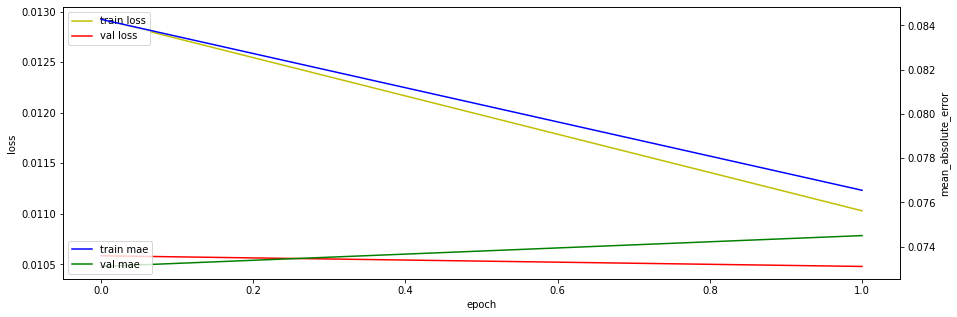

In [242]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(15, 5))

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')   # 훈련데이터의 loss (즉, mse)
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 검증데이터의 loss (즉, mse)

acc_ax.plot(hist.history['mae'], 'b', label='train mae')   # 훈련데이터의 mse
acc_ax.plot(hist.history['val_mae'], 'g', label='val mae') # 검증데이터의 mse

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mean_absolute_error')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

2022-04-05 14:46:09.325769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


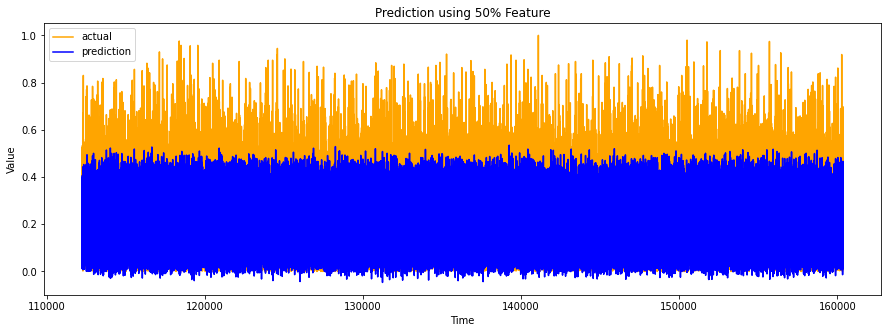

In [243]:
pred = model.predict(X_test[feature_col])
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction using 50% Feature')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

# 20개 Feature를 사용하여 DNN 모델링

In [254]:
model = dnn_modeling(20)

model.summary()

########## Start DNN Modeling ##########
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_184 (Dense)           (None, 24)                504       
                                                                 
 dense_185 (Dense)           (None, 24)                600       
                                                                 
 dense_186 (Dense)           (None, 12)                300       
                                                                 
 dense_187 (Dense)           (None, 1)                 13        
                                                                 
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


# 방법2 : 우선순위가 높은 20개 데이터를 활용하여 분석 수행

In [255]:
'''
10개에 한 번씩 업데이터 실행
0:미출력, 1:진행상황출력, 2:에포크당 출력
'''
feature_col = feature_priority['col'][:20].values

hist = model.fit(
    X_train[feature_col], y_train,
    batch_size=10,    
    epochs=5,       
    validation_split=0.2,  
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],  
    verbose=2)

# 테스트 데이터 입력
scores = model.evaluate(X_test[feature_col], y_test)
print('test_loss: ', scores[0])
print('test_mae: ', scores[1])

Epoch 1/5


2022-04-05 14:53:14.615179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-05 14:53:42.023633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8980/8980 - 33s - loss: 0.0130 - mae: 0.0842 - val_loss: 0.0112 - val_mae: 0.0746 - 33s/epoch - 4ms/step
Epoch 2/5
8980/8980 - 31s - loss: 0.0109 - mae: 0.0761 - val_loss: 0.0125 - val_mae: 0.0827 - 31s/epoch - 3ms/step
Epoch 3/5
8980/8980 - 31s - loss: 0.0105 - mae: 0.0743 - val_loss: 0.0111 - val_mae: 0.0747 - 31s/epoch - 4ms/step
Epoch 4/5
8980/8980 - 31s - loss: 0.0104 - mae: 0.0737 - val_loss: 0.0113 - val_mae: 0.0740 - 31s/epoch - 3ms/step
Epoch 5/5
8980/8980 - 31s - loss: 0.0103 - mae: 0.0733 - val_loss: 0.0106 - val_mae: 0.0733 - 31s/epoch - 3ms/step
1504/1504 [==============================] - 5s 3ms/step - loss: 0.0105 - mae: 0.0733
test_loss:  0.010535757057368755
test_mae:  0.07334552705287933


In [256]:
# 관찰된 metric 값들을 확인함
for i in range(len(scores)):
    print("%s: %.2f" % (model.metrics_names[i], scores[i]))

loss: 0.01
mae: 0.07


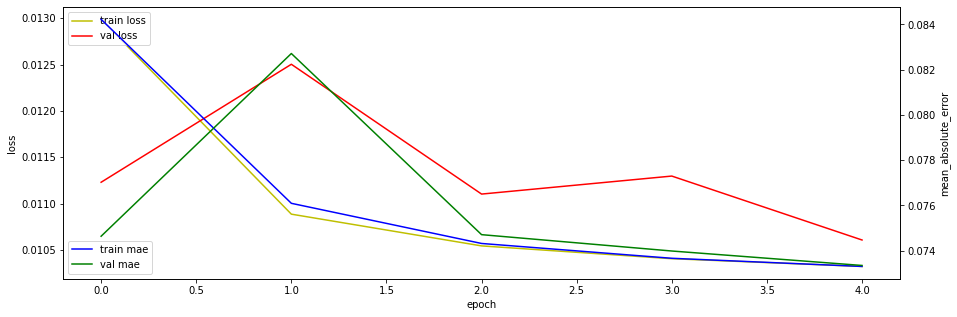

In [257]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(15, 5))

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')   # 훈련데이터의 loss (즉, mse)
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 검증데이터의 loss (즉, mse)

acc_ax.plot(hist.history['mae'], 'b', label='train mae')   # 훈련데이터의 mae
acc_ax.plot(hist.history['val_mae'], 'g', label='val mae') # 검증데이터의 mae

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mean_absolute_error')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

2022-04-05 14:47:18.804173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


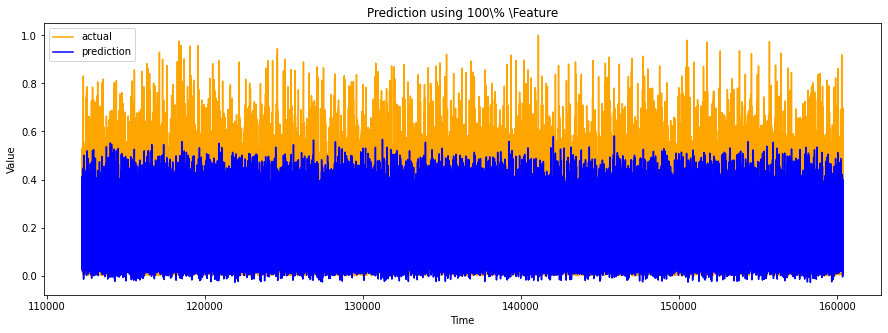

In [248]:
pred = model.predict(X_test[feature_col])
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction using 100\% \Feature')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

# 전체 Feature를 사용하여 DNN 모델링

In [259]:
model = dnn_modeling(X.shape[1])

model.summary()

########## Start DNN Modeling ##########
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_188 (Dense)           (None, 24)                600       
                                                                 
 dense_189 (Dense)           (None, 24)                600       
                                                                 
 dense_190 (Dense)           (None, 12)                300       
                                                                 
 dense_191 (Dense)           (None, 1)                 13        
                                                                 
Total params: 1,513
Trainable params: 1,513
Non-trainable params: 0
_________________________________________________________________


# 방법3 : 전체 데이터를 활용하여 분석 수행

In [260]:
'''
10개에 한 번씩 업데이터 실행
0:미출력, 1:진행상황출력, 2:에포크당 출력
'''
hist = model.fit(
    X_train, y_train,
    batch_size=10,    
    epochs=5,       
    validation_split=0.2,  
    callbacks=[EarlyStopping(monitor='val_loss', patience=10)],  
    verbose=2)

# 테스트 데이터 입력
scores = model.evaluate(X_test, y_test)
print('test_loss: ', scores[0])
print('test_mae: ', scores[1])

Epoch 1/5


2022-04-05 14:56:39.289533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-05 14:57:05.588374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8980/8980 - 32s - loss: 0.0130 - mae: 0.0849 - val_loss: 0.0116 - val_mae: 0.0762 - 32s/epoch - 4ms/step
Epoch 2/5
8980/8980 - 32s - loss: 0.0110 - mae: 0.0765 - val_loss: 0.0103 - val_mae: 0.0730 - 32s/epoch - 4ms/step
Epoch 3/5
8980/8980 - 31s - loss: 0.0108 - mae: 0.0754 - val_loss: 0.0124 - val_mae: 0.0830 - 31s/epoch - 3ms/step
Epoch 4/5
8980/8980 - 31s - loss: 0.0106 - mae: 0.0745 - val_loss: 0.0109 - val_mae: 0.0766 - 31s/epoch - 3ms/step
Epoch 5/5
8980/8980 - 31s - loss: 0.0104 - mae: 0.0740 - val_loss: 0.0100 - val_mae: 0.0715 - 31s/epoch - 3ms/step
1504/1504 [==============================] - 5s 3ms/step - loss: 0.0100 - mae: 0.0716
test_loss:  0.009953830391168594
test_mae:  0.07155383378267288


In [261]:
# 관찰된 metric 값들을 확인함
for i in range(len(scores)):
    print("%s: %.2f" % (model.metrics_names[i], scores[i]))

loss: 0.01
mae: 0.07


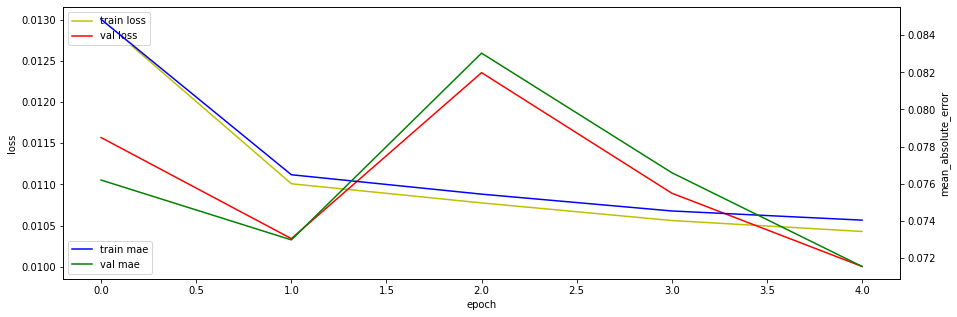

In [262]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(15, 5))

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')   # 훈련데이터의 loss (즉, mse)
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss') # 검증데이터의 loss (즉, mse)

acc_ax.plot(hist.history['mae'], 'b', label='train mae')   # 훈련데이터의 mse
acc_ax.plot(hist.history['val_mae'], 'g', label='val mae') # 검증데이터의 mse

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mean_absolute_error')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

2022-04-05 14:48:27.754794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


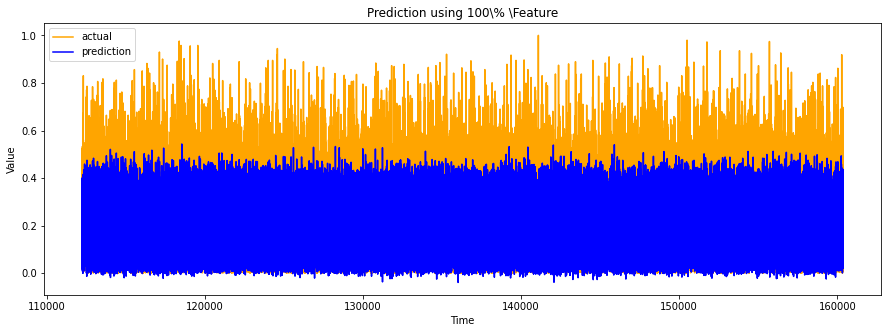

In [253]:
pred = model.predict(X_test)
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.title('Prediction using 100\% \Feature')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()